In [7]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from nltk.metrics.distance import edit_distance
from textwrap import wrap
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy

from bs4 import BeautifulSoup
from requests import get
import wikipedia

from tqdm import tqdm

import lyricsgenius as genius

# Etape 1 - Scrapping chart

##  A - Scrapping

In [ ]:
years = [str(y) for y in np.arange(2004, 2023, 1)]
weeks = [int(v) for v in np.linspace(1, 52, 12)]
mois = ["Janvier", "Fevrier", "Mars", "Avril", "Mai", "Juin", "Juillet", "Aout", "Septembre", "Octobre", "Novembre", "Decembre"]

In [ ]:
dfs_chart = {y : {} for y in years}
data = []

for y in tqdm(years):
    for k, w in enumerate(weeks):
        url = f"https://acharts.co/france_singles_top_100/{y}/{w}"
        rq = get(url)
        m = mois[k]
        if rq.ok:
            soup = BeautifulSoup(rq.text)

            chart = soup.find("table", {"id" : "ChartTable"})
            trs = chart.findAll("tr")[1:]

            for tr in trs:
                music_name = tr.find("span", {"itemprop" : "name"}).text.lower()
                rank = tr.find("span", {"itemprop" : "position"}).text.lower()
                artist_name = tr.find("span", {"itemprop" : "byArtist"}).text[2:-1].lower()
                data.append([m, y, str(rank), str(artist_name), str(music_name)])

charts = pd.DataFrame(data, columns=["Mois", "Annee", "Rank", "Artist", "Music"])

100%|██████████| 19/19 [02:32<00:00,  8.01s/it]


In [ ]:
#Export
charts.to_csv("../etapes/1 - scrapping chart/charts.csv", index=False, encoding="utf-8-sig")

## B - Analyse

In [ ]:
#Load
charts = pd.read_csv("../etapes/1 - scrapping chart/charts.csv", encoding="utf-8-sig")

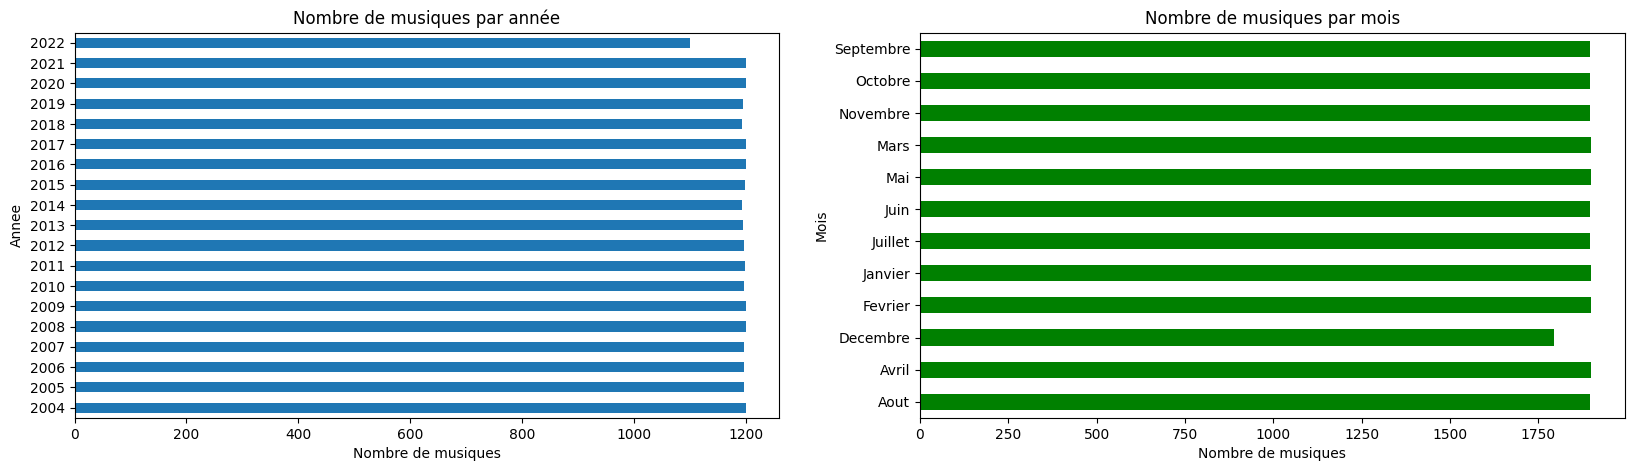

In [ ]:
#Donnée par année
fig, ax = plt.subplots(1, 2, figsize=(20,5))
charts.groupby("Annee")["Music"].count().plot.barh(ax=ax[0])
ax[0].set(title="Nombre de musiques par année", xlabel="Nombre de musiques")

charts.groupby("Mois")["Music"].count().plot.barh(ax=ax[1], color="green")
ax[1].set(title="Nombre de musiques par mois", xlabel="Nombre de musiques")

plt.show()

# Etape 2 - Cleaning chart

In [ ]:
#Load
charts = pd.read_csv("../etapes/1 - scrapping chart/charts.csv", encoding="utf-8-sig")

## A - Cleaning

In [ ]:
names = [
    ("Djadja", "Djadja et Dinaz"),
    ("Lorie", "Lorie Pester"),
    ("-m-", "Matthieu Chedid"),
    ("Priscilla", "Priscilla Betti"),
    ("I Am", "IAM"),
    ("Sofiane", "Sofiane Zermani"),
    ("Justice", "Justice (groupe)"),
    ("Soma Riba", "Collectif Métissé"),
    ("Fresh", "Fresh la Peufra"),
    ("Rosalia", "Rosalía"),
    ("Italo Brothers", "ItaloBrothers"),
    ("Far\*east Movement", "Far East Movement"),
    ("Odyssey", "Odyssey (groupe)"),
    ("1789", "1789 : Les Amants de la Bastille"),
    ("Clemence", "Clémence Saint-Preux"),
    ("Rose", "Rose (chanteuse)"),
    ("Laeti", "Laetitia Kerfa"),
    ("La Troupe", "Mozart, l'opéra rock"),
    ("Victoria", "Victoria Sio"),
    ("Christine And The Queens", "Redcar (artiste)"),
    ("Earth and Wind And Fire", "Earth, Wind And Fire"),
    ("Jean Roch", "Jean-Roch"),
    ("Keen V", "Keen'V"),
    ("Dinor", "Dinor RDT"),
    ("Koba La D", "Koba LaD"),
    ("scotts", "Travis Scott"),
    ("louane emera", "louane"),
    ("maitre gims", "gims"),
    ("p!nk", "pink"),
    ("Eva", "Eva Queen"),
    ("dj tiësto", "tiesto"),
    ("Karol", "Karol G"),
    ("Khaled", "DJ Khaled"),
    ("Black Eyed Peas", "The Black Eyed Peas"),
    ("L.E.J", "LEJ"),
    ("Disiz la peste", "Disiz"),
    ("k'maro", "k. maro"),
    ("shin sekaï", "The Shin Sekaï"),
    ("the niro", "niro"),
    ("r.i.o.", "rio"),
    ("zayn", "zayn malik"),
    ("dimitri vegas", "dimitri vegas & like mike"),
    ("cauet", "Sébastien Cauet"),
    ("do", "the do"),
    ("les filles", "Aurélie Konaté")
]

replace_words = [
    ("\x9c", "oe"),
    ("œ", "oe"),
    ("$", "S"),
]

charts["Artist"] = charts["Artist"].str.split(" x ", regex=False).str[0]
charts["Artist"] = charts["Artist"].str.split(" - ", regex=False).str[-1]
charts["Artist"] = charts["Artist"].str.split(" \+ ", regex=False).str[0]

charts["Artist"] = charts["Artist"].apply(lambda x: "star academy" if "star academy" in x else x)

for n1, n2 in names:
    charts["Artist"] = charts["Artist"].apply(lambda x: n2.lower() if x.lower() == n1.lower() else x.lower())

for n1, n2 in replace_words:
    charts["Artist"] = charts["Artist"].str.replace(n1.lower(), n2.lower(), regex=False)


In [8]:
def add_id(df : pd.DataFrame, cols : list, id_name : str):
    df_unique = df[cols].drop_duplicates(ignore_index=True)
    df_unique[id_name] = df_unique.index

    return df.merge(df_unique, on=cols, how="inner")

In [ ]:
charts = add_id(charts, ["Artist", "Music"], "id_music")

In [ ]:
#Export
charts.to_csv("../etapes/2 - cleanning chart/charts.csv", index=False, encoding="utf-8-sig")

## B - Analyse

In [ ]:
#Load
charts = pd.read_csv("../etapes/2 - cleanning chart/charts.csv", encoding="utf-8-sig")

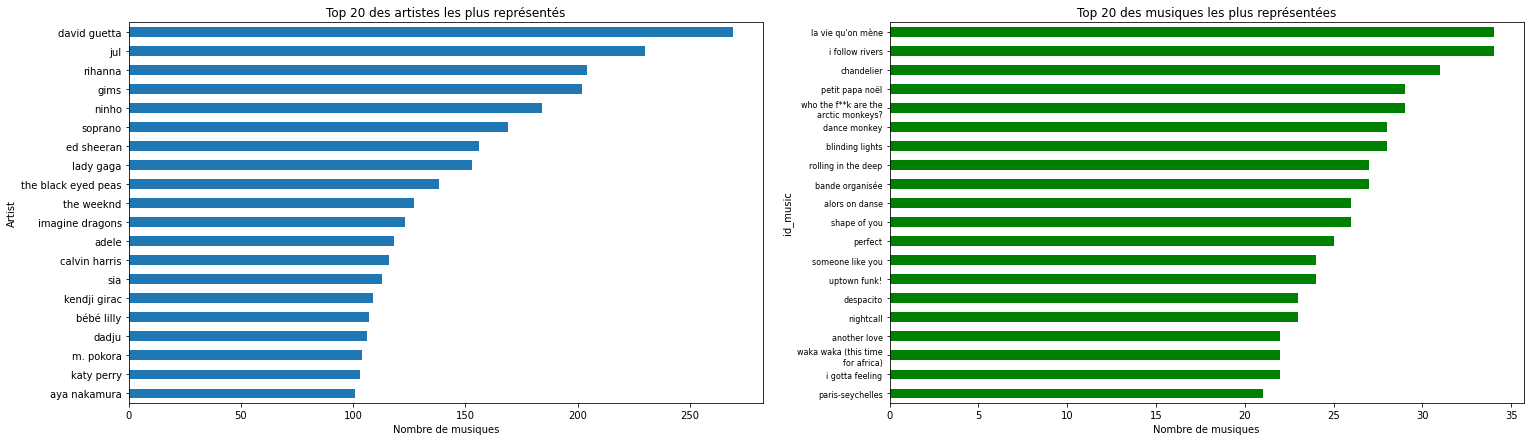

In [ ]:
top = 20

fig, ax = plt.subplots(1, 2, figsize=(25,7))
charts.groupby("Artist")["Music"].count().sort_values().iloc[-top:].plot.barh(ax=ax[0])
ax[0].set(title=f"Top {top} des artistes les plus représentés", xlabel="Nombre de musiques")

charts.groupby("id_music")["Artist"].count().sort_values().iloc[-top:].plot.barh(ax=ax[1], color="green")
ax[1].set(title=f"Top {top} des musiques les plus représentées", xlabel="Nombre de musiques")
ax[1].set_yticklabels(["\n".join(wrap(charts[charts["id_music"] == int(elem.get_text())].iloc[0,:]["Music"], 20)) for elem in ax[1].get_yticklabels()], size=8)

plt.show()

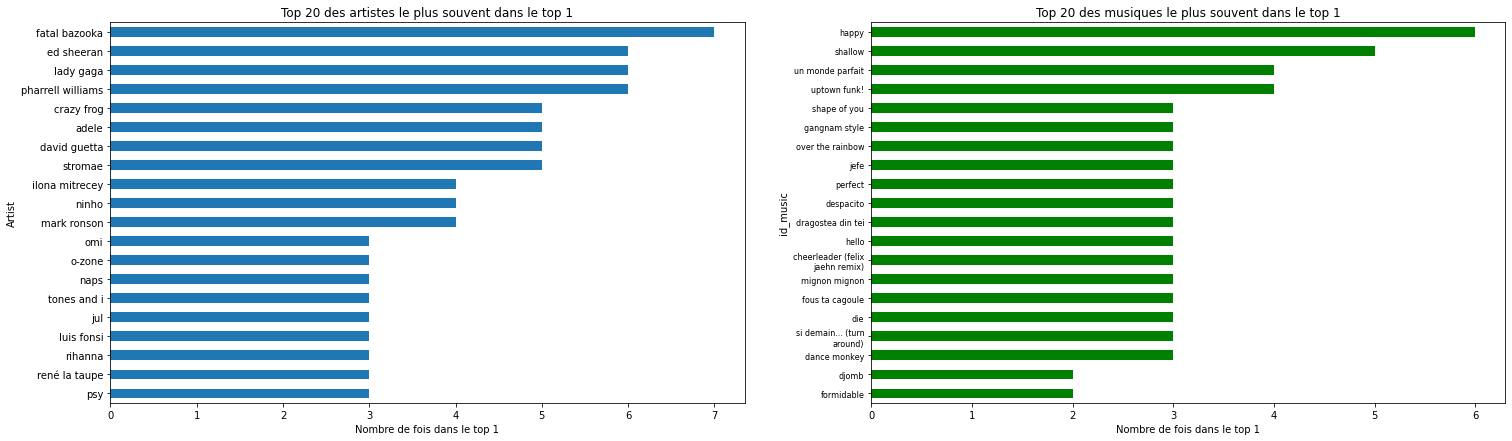

In [ ]:
top = 1

fig, ax = plt.subplots(1, 2, figsize=(25,7))
charts.groupby("Artist")["Rank"].value_counts().unstack().iloc[:, :top].sum(axis=1).sort_values().iloc[-20:].plot.barh(ax=ax[0])
ax[0].set(title=f"Top 20 des artistes le plus souvent dans le top {top}", xlabel=f"Nombre de fois dans le top {top}")

charts.groupby("id_music")["Rank"].value_counts().unstack().iloc[:, :top].sum(axis=1).sort_values().iloc[-20:].plot.barh(color="green", ax=ax[1])
ax[1].set(title=f"Top 20 des musiques le plus souvent dans le top {top}", xlabel=f"Nombre de fois dans le top {top}")
ax[1].set_yticklabels(["\n".join(wrap(charts[charts["id_music"] == int(elem.get_text())].iloc[0,:]["Music"], 20)) for elem in ax[1].get_yticklabels()], size=8)

plt.show()

David Guetta est l'artiste qui a eu le souvent ses musiques dans les top 5 français. </br>
Shallow est la musique qui est revenu le plus souvent dans le top 5.

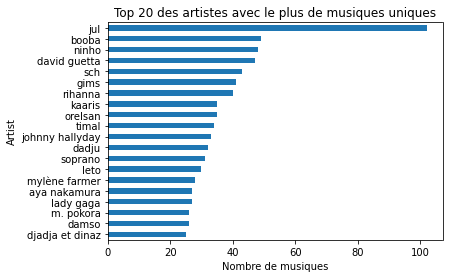

In [ ]:
charts.groupby("Artist")["id_music"].unique().agg(len).sort_values()[-20:].plot.barh()
plt.title("Top 20 des artistes avec le plus de musiques uniques")
plt.xlabel("Nombre de musiques")
plt.show()

Jul est l'artiste avec le plus de musique unique dans le top 100 depuis 2004

# Etape 3 : Scrapping artist data

In [ ]:
#Load
charts = pd.read_csv("../etapes/2 - cleanning chart/charts.csv", encoding="utf-8-sig")

## A - Scrapping

In [ ]:
def find_title_in_wikipedia(title, pourcentage=0.3):
    words = ["(chanteur)", "(chanteuse)", "(groupe)", "(rappeur)", "(rappeuse)", "(musicien)", "(chanteur français)", "(france)", "(producteur)", "(artiste)", "(groupe de musique)"]

    wikipedia.set_lang("fr")
    results = wikipedia.search(title, results=10)
    distance = []
    if len(results) > 0:
        for element in results:
            if any((w in element.lower()) and (edit_distance(element.lower().split(" (")[0].strip(), title.lower().strip())/len(title) < pourcentage) for w in words):
                return element

            distance.append(edit_distance(title.lower().strip(), element.lower().strip()))

        return results[np.argmin(distance)] if min(distance)/len(title) < pourcentage else np.NaN

In [ ]:
def wiki_birth(title):
    cols = ["Naissance", "Pays d'origine", "Origine", "Nationalité", "Pays", "Summary"]
    nats = ["franco", "français", "belge", "canadien", "libanais", "réunionnais"]
    dic = {w : np.NaN for w in cols}

    if title is np.NaN:
        return dic

    url = f"https://fr.wikipedia.org/wiki/{title}"
    rq = get(url)

    if not rq.ok:
        return dic
    
    soup = BeautifulSoup(rq.text)
    tables = soup.findAll("table")

    for table in tables:
        trs = table.findAll("tr")

        for tr in trs:
            th = tr.find("th")

            if th is not None:
                for w in cols:
                    if w in th.text:
                        td = tr.find("td")
                        if td is not None:
                            dic[w] = td.text.strip().lower()

    wikipedia.set_lang("fr")
    try:
        summary = wikipedia.summary(title, sentences=1)
        dic["Summary"] = summary.lower().strip()

        if dic["Nationalité"] is np.NaN:
            for w in nats:
                if w in summary:
                    dic["Nationalité"] = w.lower().strip()
                    return dic
    except:
        pass

    return dic

In [ ]:
#Récupére tous les artistes uniques
artist = pd.DataFrame(charts["Artist"].unique(), columns=["Artist"])

In [ ]:
artist["Artist_wiki"] = artist["Artist"].apply(lambda x : find_title_in_wikipedia(x, 0.2)) #Trouve les pages wikipedia de chaque artistes

In [ ]:
birth_dic = artist["Artist_wiki"].apply(wiki_birth) #Cherche les infos de naissance sur les pages wikipedia

C:\Users\CYTech Student\AppData\Roaming\Python\Python38\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\CYTech Student\AppData\Roaming\Python\Python38\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [ ]:
#Transforme les infos trouver sur wikipédia en dataframe
dfs_birth = []
for dic in birth_dic:
    dfs_birth.append(pd.DataFrame(dic, index=[0]))
birth = pd.concat(dfs_birth, ignore_index=True)

In [ ]:
#Merge les infos de naissance avec les infos des artistes
artist = artist.merge(birth, left_index=True, right_index=True)

In [ ]:
#On ajoute manuellement les informations pour les artistes importants qui n'ont pas été trouvé sur wikipedia
manuel_names = [
    ("sound of legend", "MANUEL", np.NaN, np.NaN, np.NaN, "français", np.NaN, np.NaN),
    ("al. hy", "MANUEL", "15 novembre 1993", np.NaN, np.NaN, "français", np.NaN, "15 novembre 1993 (Âge: 29 ans), Saint-Amand-les-Eaux"),
    ("glk", "MANUEL", np.NaN, np.NaN, np.NaN, "français", np.NaN, "Originaire de Bobigny, en Seine-Saint-Denis"),
    ("paul glaeser", "MANUEL", "1963", np.NaN, np.NaN, "français", np.NaN, np.NaN),
    ("bolémvn", "MANUEL", "29 novembre 1996", np.NaN, np.NaN, "français", np.NaN, "Bryan Mounkala (né le 29 novembre 1996) mieux connu sous le nom de Bolémvn est un rappeur français d'Évry, Essonne, Île-de-France, France."),
    ("1pliké140", "MANUEL", "1963", np.NaN, np.NaN, "français", np.NaN, "1PLIKÉ140 est un jeune rappeur français originaire de Clamart (92) en banlieue parisienne."),
    ("jérôme collet", "MANUEL", np.NaN, np.NaN, np.NaN, "français", np.NaN, np.NaN),
    ("tom snare", "MANUEL", np.NaN, np.NaN, np.NaN, "français", np.NaN, "Xavier Decanter, mieux connu sous son nom de scène Tom Snare, est un DJ et producteur de disques français originaire de Dunkerque."),
    ("funnybear", "MANUEL", "22 janvier 1991", np.NaN, np.NaN, "français", np.NaN, "22 janvier 1991 (Âge: 31 ans), Hyères"),
    ("landy", "MANUEL", "2000", np.NaN, np.NaN, "français", np.NaN, "Dylan Sylla Gahoussou, « Landy » de son nom de scène, est né dans le XIXe arrondissement de Paris"),
    ("dry", "MANUEL", "19 novembre 1977", np.NaN, np.NaN, "français", np.NaN, "Landry Delica a grandi à Sevran en Seine-Saint-Denis"),
    ("sasso", "MANUEL", np.NaN, np.NaN, np.NaN, "français", np.NaN, "Né à Vénissieux d'un père togolais et d'une mère marocaine"),
    ("neïman", "MANUEL", np.NaN, np.NaN, np.NaN, "guyanais", np.NaN, "NEÏMAN est un chanteur et toaster français de dancehall et de reggae-soul né RAY NEÏMAN en Guyane."),
    ("isk", "MANUEL", "20 mars 2003", np.NaN, np.NaN, "français", np.NaN, "ISK, de son vrain nom Kais Ben Baccar, est un rappeur français d'origine tunisienne, né au Canada. Habitant La Ferté-sous-Jouarre (77), il est membre du label Bendo 11 Records sous la division rap GrandLine."),
    ("yaro", "MANUEL", "1996", np.NaN, np.NaN, "français", np.NaN, "Yaro, anciennement Sirsy, est un rappeur français originaire de la ville de Yerres dans l'Essonne.")
]

In [ ]:
manuel_artist = pd.DataFrame(manuel_names, columns=["Artist", "Artist_wiki", "Naissance", "Pays d'origine", "Origine", "Nationalité", "Pays", "Summary"])

In [ ]:
artist_to_drop = artist[artist["Artist"].isin(manuel_artist["Artist"])].index
artist.drop(index=artist_to_drop, inplace=True)

In [ ]:
artist = pd.concat([artist, manuel_artist])

In [ ]:
#Export
artist.to_csv("../etapes/3 - scrapping artist data/artist.csv", encoding="utf-8-sig", index=False)

## B - Analyse

In [ ]:
#Load
artist = pd.read_csv("../etapes/3 - scrapping artist data/artist.csv", encoding="utf-8-sig")

In [ ]:
artist.value_counts("Artist_wiki").value_counts() #Aucune page en wiki en double, ce qui est un bon signe !

1     1700
15       1
dtype: int64

In [ ]:
charts_c = charts.copy().drop(columns=["Rank", "Annee", "Mois"]).drop_duplicates()
charts_c = charts_c.merge(artist, on="Artist", how="left")

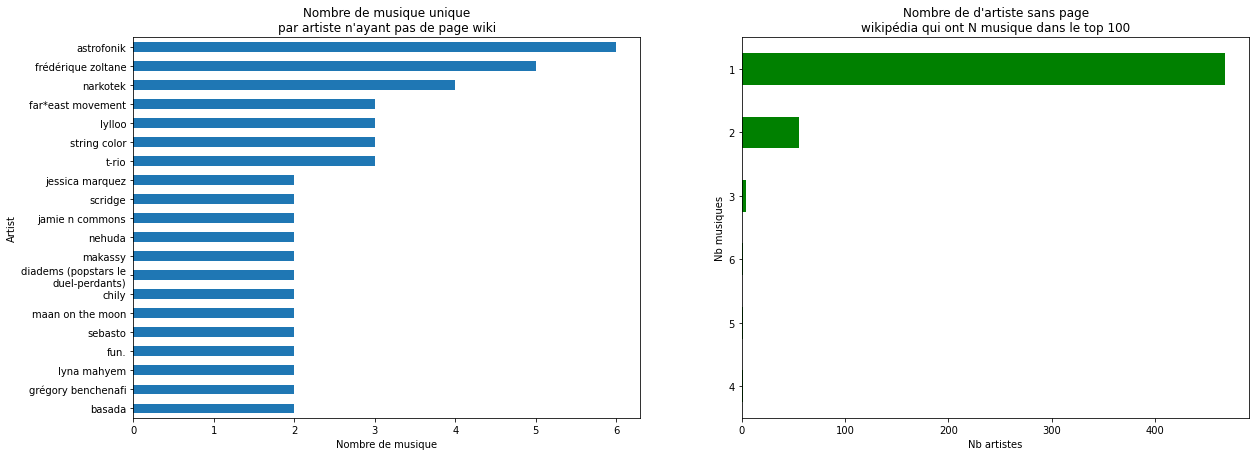

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20,7))

charts_c[charts_c["Artist_wiki"].isna()].groupby("Artist")["Music"].count().sort_values()[-20:].plot.barh(ax=ax[0])
ax[0].set(title="Nombre de musique unique\npar artiste n'ayant pas de page wiki", xlabel="Nombre de musique")
ax[0].set_yticklabels(["\n".join(wrap(elem.get_text(), 20)) for elem in ax[0].get_yticklabels()])


charts_c[charts_c["Artist_wiki"].isna()].groupby("Artist")["Music"].count().value_counts()[::-1].plot.barh(ax=ax[1], color="green")
ax[1].set(xlabel="Nb artistes", ylabel="Nb musiques", title="Nombre de d'artiste sans page\nwikipédia qui ont N musique dans le top 100")
plt.show()

On remarque qu'il y a beaucoup d'artistes qui n'ont fait qu'une ou deux musiques populaires, ce qui parait logique de ne pas trouver beaucoup d'information sur eux. </br>
Seul quelques artistes sortent du lot, et après recherche, soit l'artiste n'est pas français, soit il y a trop peu d'infos sur eux.

In [66]:
def pie_chart(df, col, title, na=True, legends=[], colors=["green", "red"], figsize=(3,3)):
    if na:
        df[col].isna().value_counts(normalize=True).round(2).plot.pie(autopct="%.2f%%", figsize=figsize, colors=colors)
    else:
        df[col].value_counts(normalize=True).round(2).plot.pie(autopct="%.2f%%", figsize=figsize, colors=colors)
    plt.title(title, color='white')
    plt.gcf().set_facecolor('black')
    plt.legend(legends, bbox_to_anchor=(1, 0.5))
    plt.show()

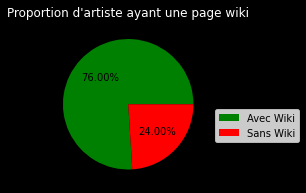

In [ ]:
pie_chart(artist, "Artist_wiki", "Proportion d'artiste ayant une page wiki", legends=["Avec Wiki", "Sans Wiki"])

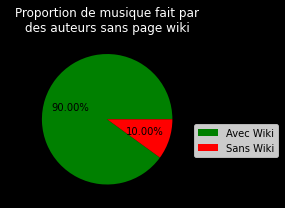

In [ ]:
pie_chart(charts_c, "Artist_wiki", "Proportion de musique fait par\ndes auteurs sans page wiki", legends=["Avec Wiki", "Sans Wiki"])

In [ ]:
artist = artist[~artist["Artist_wiki"].isna()] #On ne garde que les artistes qui ont une page wiki

In [ ]:
#On recalcul les distances entre les noms d'artistes et les pages wikipédia pour vérifier
def calc_dist(artist, wiki):
    if wiki == "MANUEL":
        return 0

    words = ["(chanteur)", "(chanteuse)", "(groupe)", "(rappeur)", "(rappeuse)", "(musicien)", "(chanteur français)", "(france)", "(producteur)", "(artiste)", "(groupe de musique)"]

    if any(w in wiki.lower() for w in words):
        dist = edit_distance(artist.lower().strip(), wiki.lower().split(" (")[0].strip())
        if dist/len(artist) < 0.4:
            return dist
    
    return edit_distance(artist.lower().strip(), wiki.lower().strip())

In [ ]:
artist["distance"] = artist.apply(lambda x: calc_dist(x["Artist"], x["Artist_wiki"]), axis=1)
artist["distance_norm"] = artist.apply(lambda x : x["distance"]/len(x["Artist"]), axis=1)

In [ ]:
artist.sort_values("distance_norm", ascending=False).head() #Nos distances sont bonnes

,Artist,Artist_wiki,Naissance,Pays d'origine,Origine,Nationalité,Pays,Summary,distance,distance_norm
887,ouf le prof,Ouf le prof !,NaN,france,NaN,NaN,france,ouf le prof !,2,0.181818
1551,simon & garfunkel,Simon and Garfunkel,NaN,états-unis,NaN,NaN,états-unis,simon and garfunkel [ˈsaɪmən ən gɑrfʌnkəl] est...,3,0.176471
760,gullia,Gulli,NaN,NaN,NaN,NaN,france,NaN,1,0.166667
20,cerena,Cérena,20 juin 1981 (41 ans)bastia (haute-corse),NaN,NaN,français,NaN,"cérena, de son vrai nom marie-ange cerezuela, ...",1,0.166667
1138,the do,The Dø,NaN,france,NaN,français,france,the dø [ðœ do] est un groupe français d'indie...,1,0.166667


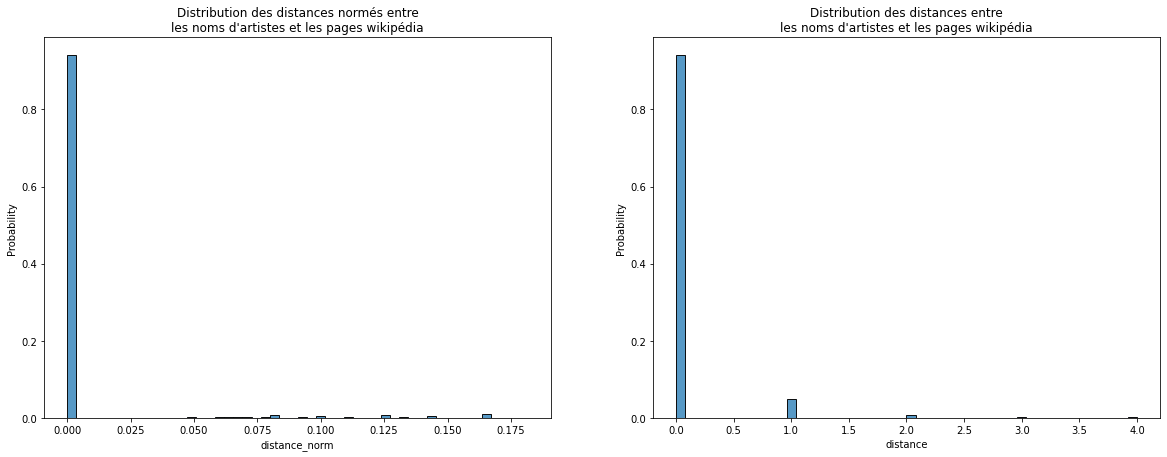

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20,7))

sns.histplot(x = "distance_norm", data=artist, bins=50, stat="probability", ax=ax[0])
ax[0].set_title("Distribution des distances normés entre\nles noms d'artistes et les pages wikipédia")

sns.histplot(x = "distance", data=artist, bins=50, stat="probability", ax=ax[1])
ax[1].set_title("Distribution des distances entre\nles noms d'artistes et les pages wikipédia")

plt.show()

# Etape 4 : Cleanning wikipedia results

## A - Nationalité/Pays

In [ ]:
#Load
artist = pd.read_csv("../etapes/3 - scrapping artist data/artist.csv", encoding="utf-8-sig")
charts = pd.read_csv("../etapes/2 - cleanning chart/charts.csv", encoding="utf-8-sig")

In [ ]:
nationality_cols = ["Nationalité", "Origine", "Pays", "Pays d'origine"]

### 1 - Artiste sans donnée

In [ ]:
artist_org = artist.copy()

In [ ]:
#Ajout de la colonne "No data" pour voir ceux sur qui on n'a pas de données
artist["No data"] = (
    (artist["Naissance"].isna()) &
    (artist["Pays d'origine"].isna()) &
    (artist["Origine"].isna()) &
    (artist["Nationalité"].isna()) &
    (artist["Pays"].isna()) &
    (artist["Summary"].isna())
)

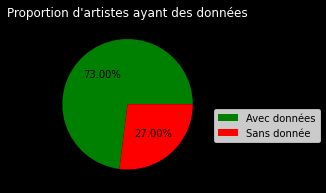

In [ ]:
pie_chart(artist, "No data", "Proportion d'artistes ayant des données", False, ["Avec données", "Sans donnée"])

In [ ]:
charts_c = charts.copy().merge(artist, left_on="Artist", right_on="Artist", how="right")

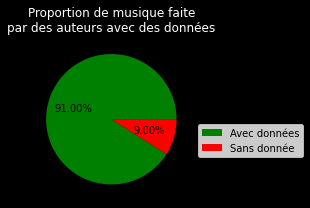

In [ ]:
pie_chart(charts_c, "No data", "Proportion de musique faite\npar des auteurs avec des données", False, ["Avec données", "Sans donnée"])

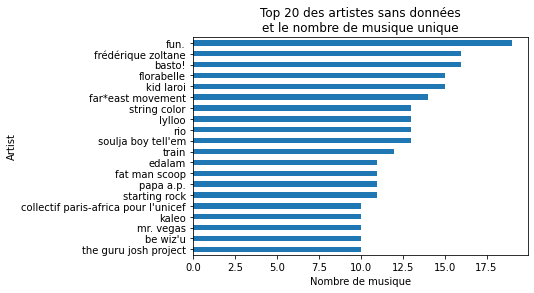

In [ ]:
charts_c[charts_c["No data"]].groupby("Artist")["Music"].count().sort_values()[-20:].plot.barh()
plt.title("Top 20 des artistes sans données\net le nombre de musique unique")
plt.xlabel("Nombre de musique")
plt.show()

In [ ]:
artist = artist[~artist["No data"]] #On ne garde que les artistes pour lesquels on a des données

### 2 - Normalisation des nationalités et pays récupéré

In [75]:
def category_count(cols, df, figsize=(40,7), top=10):
    length = []
    for col in cols:
        length.append(len(df[col].unique()))

    fig, ax = plt.subplots(1, len(cols)+1, figsize=figsize)

    sns.barplot(x=cols, y=length, ax=ax[0])
    ax[0].set_title("Nombre de valeurs différentes pour chaque colonne")

    for axi, col in zip(ax[1:], cols):
        df[col].value_counts().head(top)[::-1].plot.barh(ax=axi)
        axi.set(title=f"Top {top} de {col}", xlabel="Nombre d'occurence")
        axi.set_yticklabels(["\n".join(wrap(elem.get_text(), 10)) for elem in axi.get_yticklabels()])

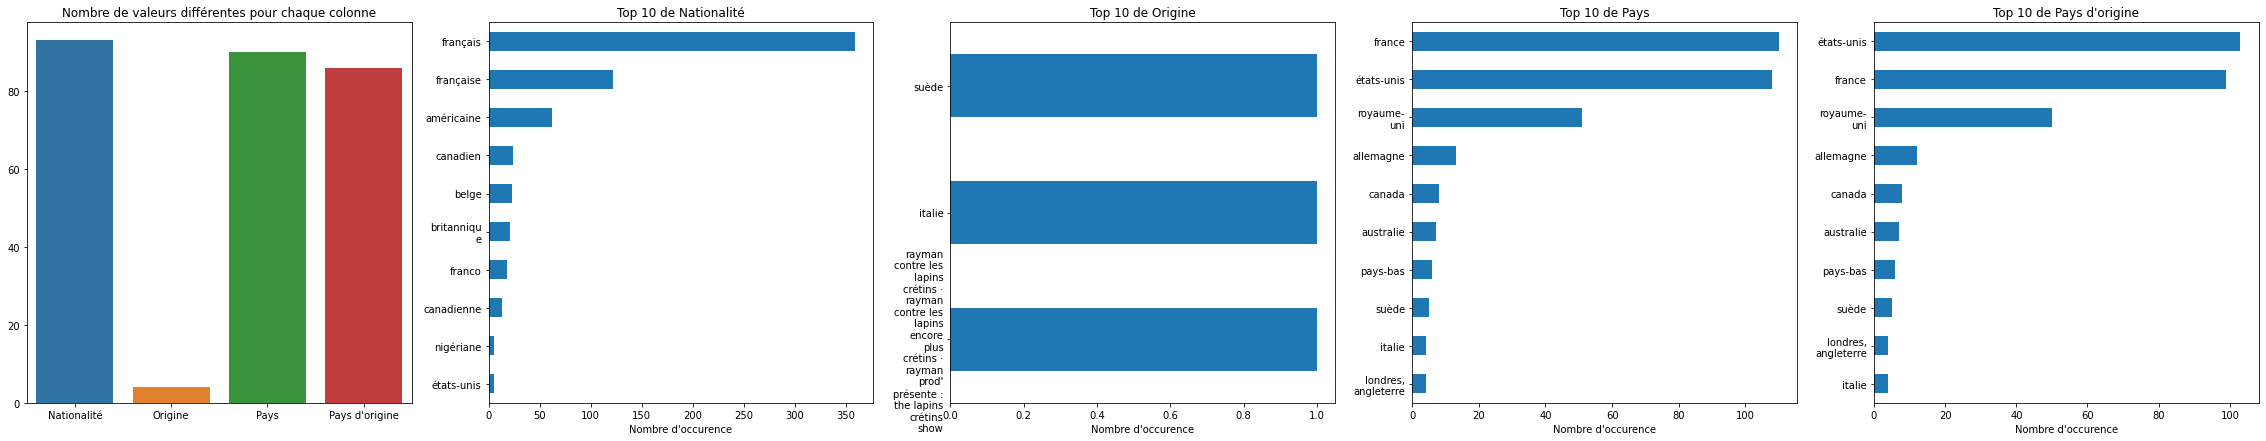

In [ ]:
category_count(nationality_cols, artist, top=10)

On se rends compte qu'il y a pleins de nationalité/pays différents et qu'on pourrait en grouper certain.

In [ ]:
#On supprime les textes dépassant les 40 caractères
for col in nationality_cols:
    artist.loc[~artist[col].isna(), col] = artist.loc[~artist[col].isna(), col].apply(lambda x: np.NaN if len(x) > 40 else x)

In [ ]:
#Importation des pays et des gentillé associer
gentille_df = pd.read_csv("../monde/gentille.csv")
gentille = gentille_df["gentille"].drop_duplicates().tolist()
pays = gentille_df["pays"].drop_duplicates().tolist()

In [ ]:
#On cherche dans les pays si on trouve quelque chose de connu
for p in pays:
    rgx = r"([\d)()\], ]|^)"+ p.lower() + r"([.,\[) ]|$)"
    artist.loc[artist["Pays"].str.contains(rgx, regex=True, na=False), "Pays"] = p
    artist.loc[artist["Pays d'origine"].str.contains(rgx, regex=True, na=False), "Pays d'origine"] = p

C:\Users\CYTech Student\AppData\Local\Temp\ipykernel_3452\3502182545.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  artist.loc[artist["Pays"].str.contains(rgx, regex=True, na=False), "Pays"] = p
C:\Users\CYTech Student\AppData\Local\Temp\ipykernel_3452\3502182545.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  artist.loc[artist["Pays d'origine"].str.contains(rgx, regex=True, na=False), "Pays d'origine"] = p


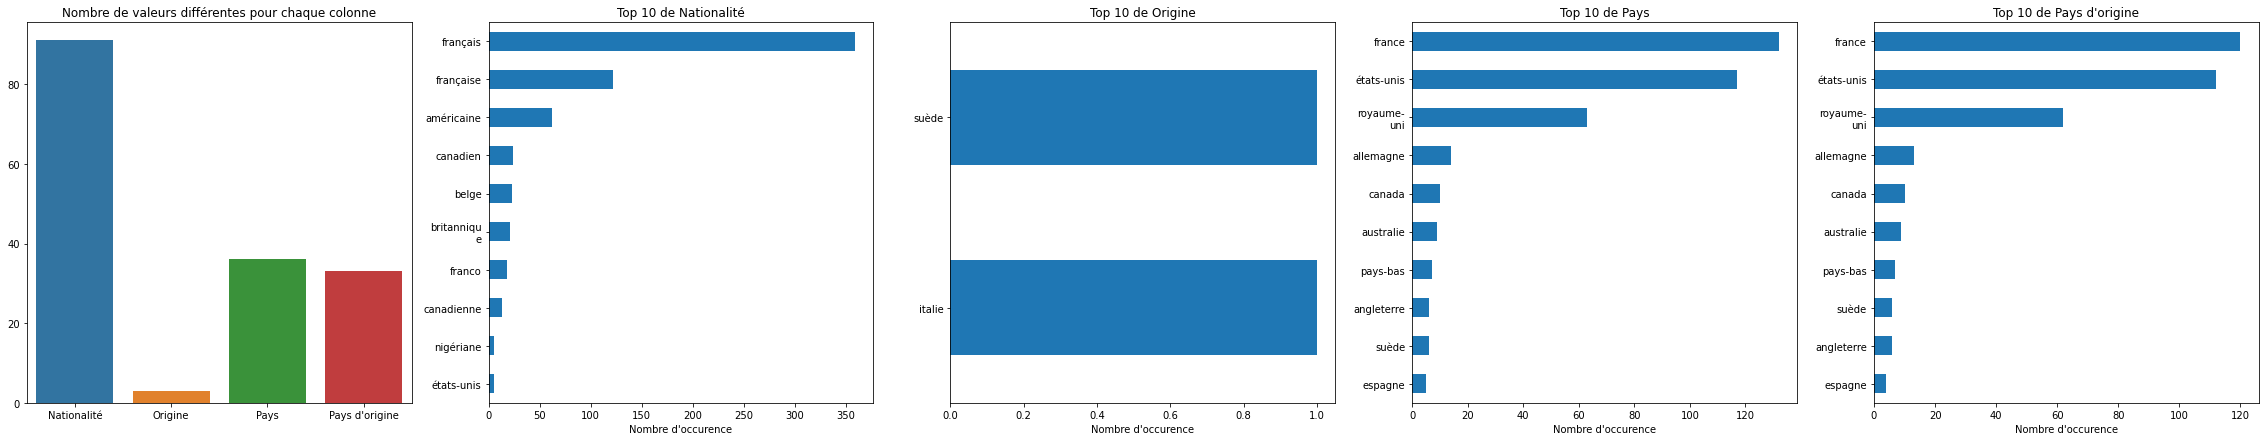

In [ ]:
category_count(nationality_cols, artist)

On a enlevé les valeurs aberrantes et réduit de moitié pays et pays d'origne.

In [ ]:
#Cela va permettre de normaliser les noms des pays et des nationalités
def cleanning(data, replace_words, p=0.3):
    if data is np.NaN:
        return np.NaN
    
    distances = []
    for r in replace_words:
        distances.append(edit_distance(data.lower(), r.lower())/len(data))
    return replace_words[np.argmin(distances)] if np.min(distances) < p else np.NaN

In [ ]:
artist["Nationalité"] = artist["Nationalité"].apply(lambda x : cleanning(x, gentille))

In [ ]:
artist["Origine"] = artist["Origine"].apply(lambda x : cleanning(x, pays))
artist["Pays"] = artist["Pays"].apply(lambda x : cleanning(x, pays))
artist["Pays d'origine"] = artist["Pays d'origine"].apply(lambda x : cleanning(x, pays))

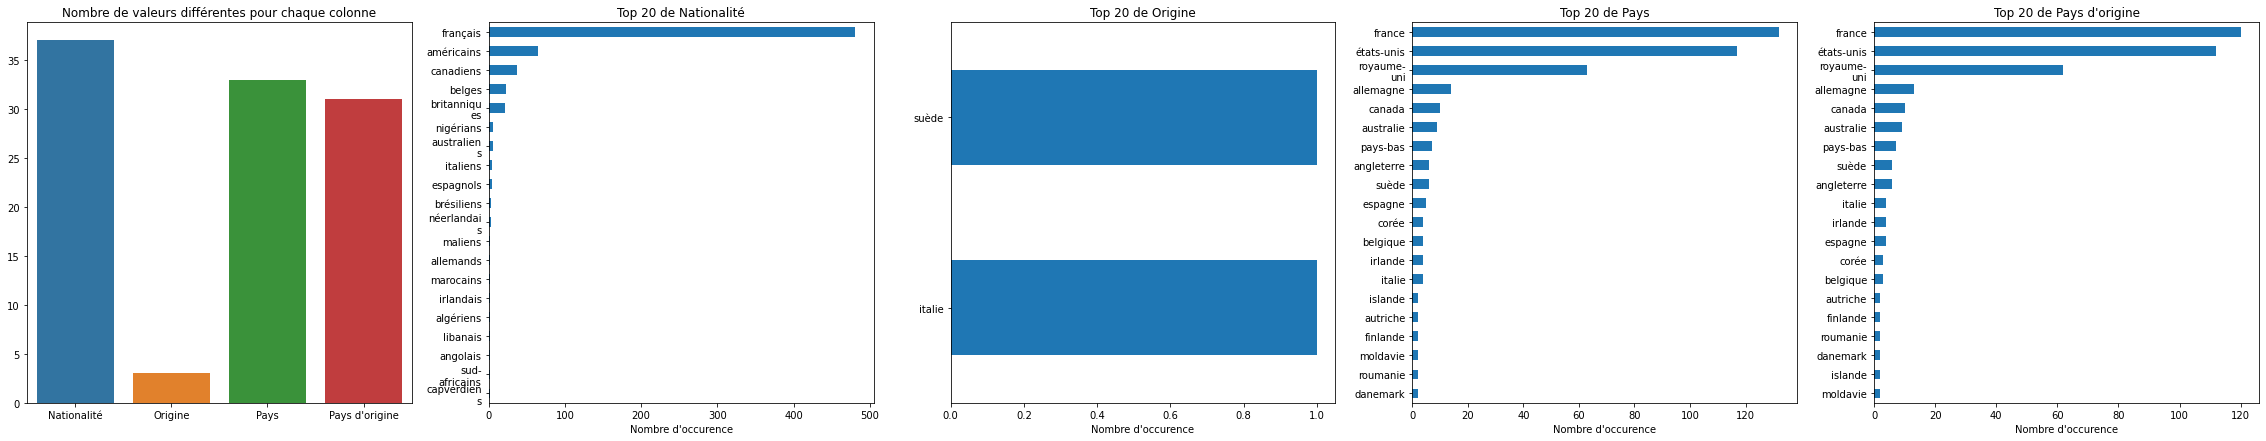

In [ ]:
category_count(nationality_cols, artist, top=20)

### 3 - Récupération de nouvelles nationalités et pays

Maintenant que nous avons normalisé l'écriture des pays et nationalité on va essayer d'en chercher de nouveau pour les artistes qui n'en n'ont pas. A l'aide du summary et naissance.

In [ ]:
artist["No nationality"] = (
    (artist["Nationalité"].isna()) &
    (artist["Origine"].isna()) &
    (artist["Pays"].isna()) &
    (artist["Pays d'origine"].isna())
)

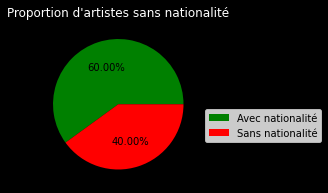

In [ ]:
pie_chart(artist, "No nationality", "Proportion d'artistes sans nationalité", False, ["Avec nationalité", "Sans nationalité"])

In [ ]:
def get_nationality(data_to_check, check_list):
    if data_to_check is np.NaN:
        return np.NaN
        
    for r in check_list:
        regex = r"([\d)()\], ]|^)"+ r.lower() + r"([.,\[) ]|$)"

        if not re.search(regex, data_to_check.lower()) is None:
            return r.lower()
    return np.NaN

In [ ]:
#On utilise le summary pour récupérer la nationalité
avant = artist[artist["Nationalité"].isna()].shape[0]

nats = artist[~artist["Nationalité"].isna()]["Nationalité"].unique()
artist.loc[artist["Nationalité"].isna(), "Nationalité"] = artist.loc[artist["Nationalité"].isna(), "Summary"].apply(lambda x: get_nationality(x, nats))         #Je récupère une première fois avec les nationalités déjà connues
artist.loc[artist["Nationalité"].isna(), "Nationalité"] = artist.loc[artist["Nationalité"].isna(), "Summary"].apply(lambda x: get_nationality(x, gentille))     #Je récupère une deuxième fois avec les gentilles

apres = artist[artist["Nationalité"].isna()].shape[0]

print(f"On a récupéré {avant-apres} nationalités")

On a récupéré 88 nationalités


In [ ]:
#On utilise le summary pour récupérer la Pays
avant = artist[(artist["Pays"].isna()) & (artist["Nationalité"].isna())].shape[0]

artist.loc[(artist["Pays"].isna()) & (artist["Nationalité"].isna()), "Pays"] = artist.loc[(artist["Pays"].isna()) & (artist["Nationalité"].isna()), "Naissance"].apply(lambda x: get_nationality(x, pays)) #Je récupère une première fois sur les naissances
artist.loc[(artist["Pays"].isna()) & (artist["Nationalité"].isna()), "Pays"] = artist.loc[(artist["Pays"].isna()) & (artist["Nationalité"].isna()), "Summary"].apply(lambda x: get_nationality(x, pays))   #Je récupère une deuxième fois sur le summary

apres = artist[(artist["Pays"].isna()) & (artist["Nationalité"].isna())].shape[0]

print(f"On a récupéré {avant - apres} pays")

On a récupéré 433 pays


In [ ]:
#Mise à jour
artist["No nationality"] = (
    (artist["Nationalité"].isna()) &
    (artist["Origine"].isna()) &
    (artist["Pays"].isna()) &
    (artist["Pays d'origine"].isna())
)

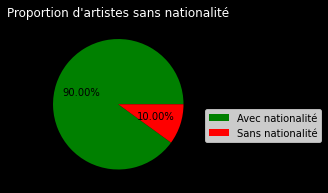

In [ ]:
pie_chart(artist, "No nationality", "Proportion d'artistes sans nationalité", False, ["Avec nationalité", "Sans nationalité"])

In [ ]:
avant = artist[artist["Nationalité"].isna()].shape[0]

In [ ]:
for col in gentille_df.columns:
    gentille_df[col] = gentille_df[col].str.strip()

gentille = pd.DataFrame.to_dict(gentille_df.set_index("pays"), orient="dict").get("gentille")

In [ ]:
#On récupère la nationalité à partir du pays et origine
for k, v in gentille.items():
    artist.loc[(artist["Nationalité"].isna()) & (artist["Pays"] == k), "Nationalité"] = v
    artist.loc[(artist["Nationalité"].isna()) & (artist["Pays d'origine"] == k), "Nationalité"] = v
    artist.loc[(artist["Nationalité"].isna()) & (artist["Origine"] == k), "Nationalité"] = v

In [ ]:
apres = artist[artist["Nationalité"].isna()].shape[0]
print(f"On a récupéré {avant-apres} nationalités")

On a récupéré 699 nationalités


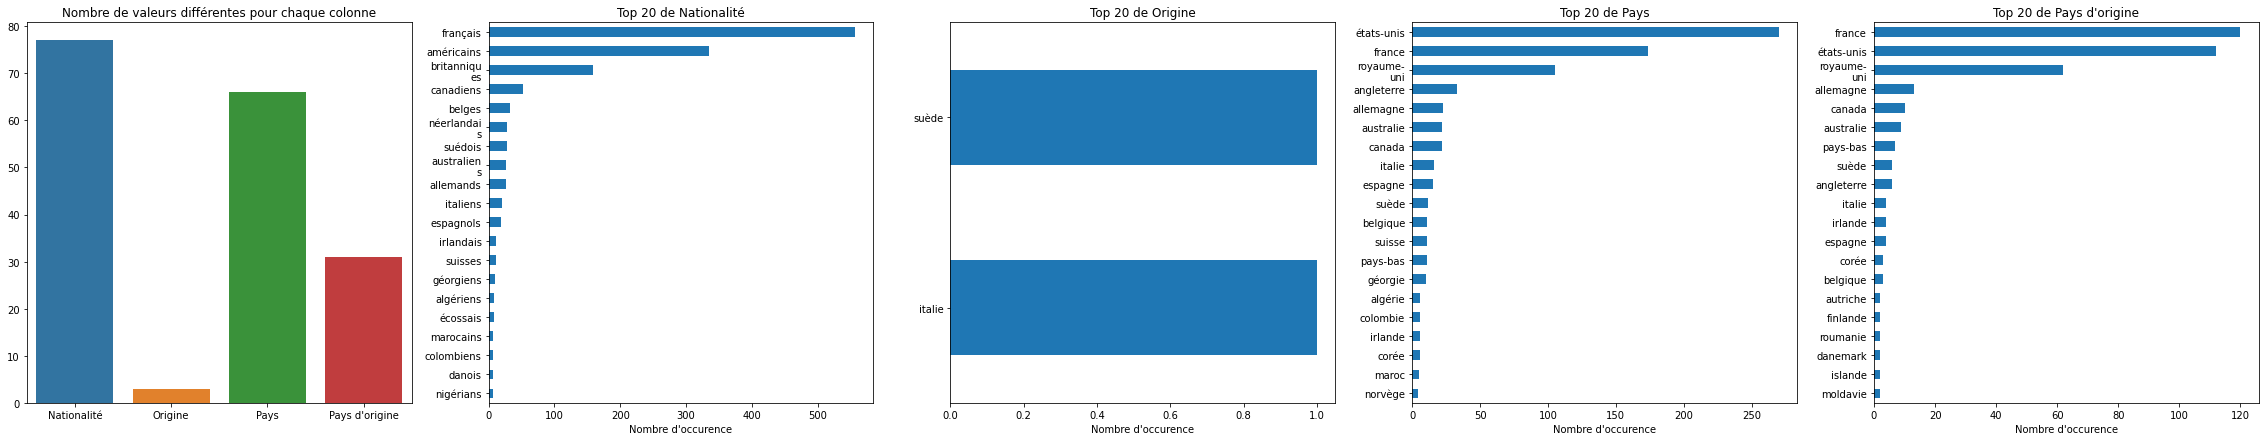

In [ ]:
category_count(nationality_cols, artist, top=20)

In [ ]:
charts_c = charts.copy().merge(artist, left_on="Artist", right_on="Artist", how="left").drop(columns=["Rank","Annee", "Mois"]).drop_duplicates()

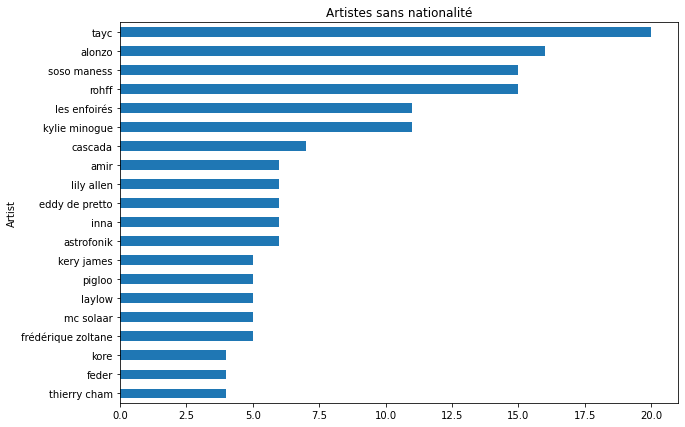

In [ ]:
charts_c[charts_c["Nationalité"].isna()].groupby("Artist")["Music"].count().sort_values()[-20:].plot.barh(figsize=(10,7))
plt.title("Artistes sans nationalité")
plt.show()

In [ ]:
#Export
artist.to_csv("../etapes/4 - cleanning wikipedia results/nationalité_pays/artist.csv", encoding="utf-8-sig", index=False)

## B - Commune/Departement/Region

In [ ]:
#Load
artist = pd.read_csv("../etapes/4 - cleanning wikipedia results/nationalité_pays/artist.csv", encoding="utf-8-sig")

In [ ]:
#Importation des données
region = pd.read_csv("../france/departements-france.csv")
departement = pd.read_csv("../france/departements-france.csv")
commune = pd.read_csv("../france/communes-departement-region.csv")
nb_habitant = pd.read_csv("../france/nb_habitant.csv")

In [ ]:
#On supprime les colonnes inutiles
commune = commune.drop(columns = ["code_commune_INSEE", "nom_commune_postal", "code_postal", "libelle_acheminement", "ligne_5", "latitude", "longitude", "code_commune", "article", "code_departement", "code_region", "nom_commune"])

#On rename la colonne nom_commune_complet en nom_commune
commune = commune.rename(columns={"nom_commune_complet": "nom_commune"})

#On enleve les arrondisement des villes
commune.loc[commune["nom_commune"].str.contains(r"[A-Za-z]* [0-9]{2}"), "nom_commune"] = commune.loc[commune["nom_commune"].str.contains(r"[A-Za-z]* [0-9]{2}"), "nom_commune"].str[:-3]

#On ajoute le nombre d'habitant au commune
commune = commune.merge(nb_habitant[["Ville", "nb_habitant"]], left_on="nom_commune", right_on="Ville", how="inner").drop(columns=["Ville"]).dropna().drop_duplicates()

#On transforme le nb d'habitant en int
commune["nb_habitant"] = commune["nb_habitant"].str.replace(" ", "")
commune["nb_habitant"] = commune["nb_habitant"].astype("int")

#On transforme tout en lower
for col in commune.select_dtypes("object").columns:
    commune[col] = commune[col].str.lower()

In [ ]:
#Permet de récupérer la localisation d'un artiste à partir de sa naissance ou sommaire wikipedia
def get_localisation(row, localisation):
    for r in localisation:
        regex = r"([\d)()\] ]|^)" + r.lower() + r"([.,\[) ]|$)"

        if (not re.search(regex, str(row["Summary"]).lower()) is None) or (not re.search(regex, str(row["Naissance"]).lower()) is None):
            return r.lower()
    return np.NaN

In [ ]:
#On récupère la région
artist["Region"] = artist.apply(lambda x: get_localisation(x, commune["nom_region"]), axis=1)

In [ ]:
#On récupère la commune
artist["Commune"] = artist.apply(lambda x: get_localisation(x, commune[commune["nb_habitant"] > 2000]["nom_commune"]), axis=1)

In [ ]:
#On récupère le département
artist["Departement"] = artist.apply(lambda x: get_localisation(x, commune["nom_departement"]), axis=1)

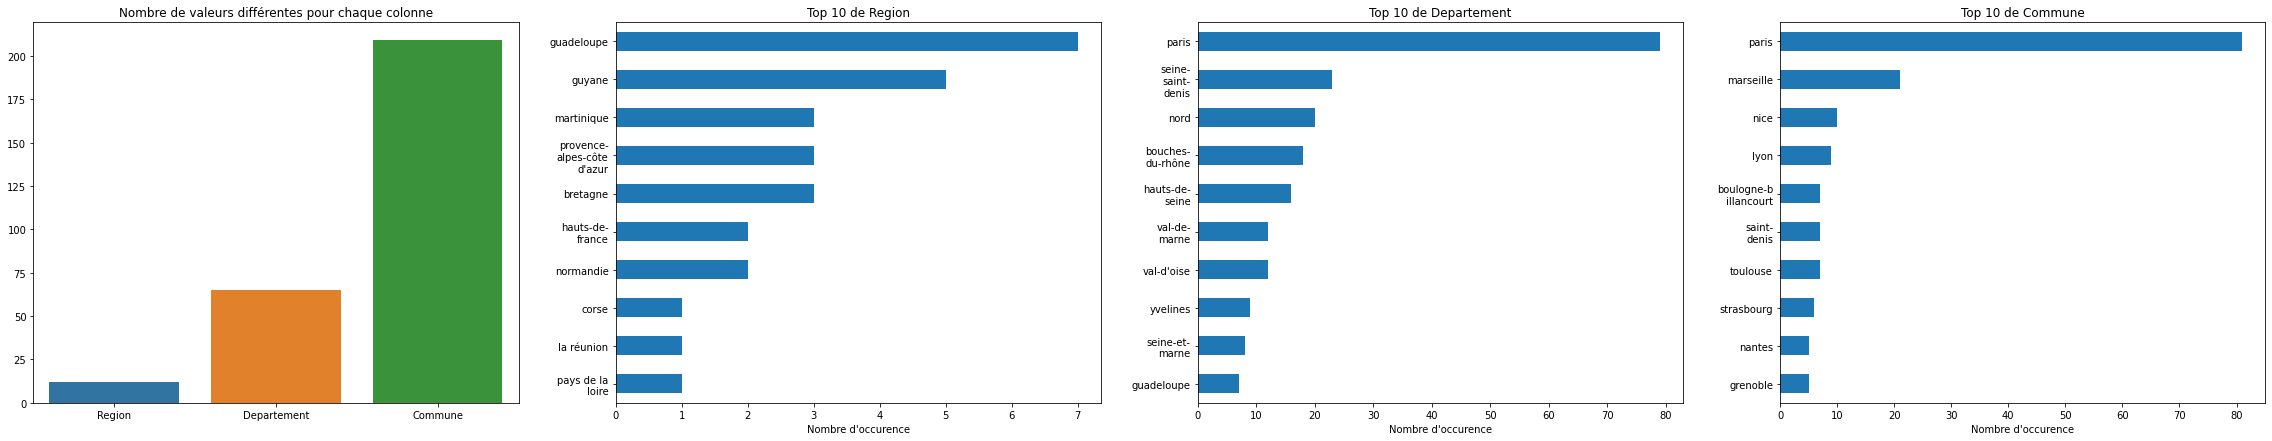

In [ ]:
category_count(["Region", "Departement", "Commune"], artist, top=10)

In [ ]:
#Artiste sans localisation
artist["No localisation"] = (
    (artist["Region"].isna()) &
    (artist["Commune"].isna()) &
    (artist["Departement"].isna())
)

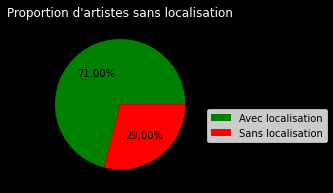

In [ ]:
pie_chart(artist, "No localisation", "Proportion d'artistes sans localisation", False, ["Avec localisation", "Sans localisation"])

In [ ]:
avant = artist[artist["Nationalité"].isna()].shape[0]

# Les artistes pour qui ont a trouvé une commune/departement/region on leur donne la nationalité française
artist.loc[(artist["Nationalité"].isna()) & (~artist["No localisation"]), "Nationalité"] = "français"

apres = artist[artist["Nationalité"].isna()].shape[0]
print(f"On a récupéré {avant-apres} nationalités")

On a récupéré 25 nationalités


In [ ]:
#Permet de récupérer le département à partir de la commune
def commune_to_departement(x : str):
    value = commune.loc[commune["nom_commune"] == x, "nom_departement"].values
    if len(value) > 0:
        return value[0]
    else:
        return np.NaN

In [ ]:
#On ajoute les departements pour les communes
artist.loc[(~artist["Commune"].isna()) & (artist["Departement"].isna()), "Departement"] = artist.loc[(~artist["Commune"].isna()) & (artist["Departement"].isna()), "Commune"].apply(commune_to_departement)

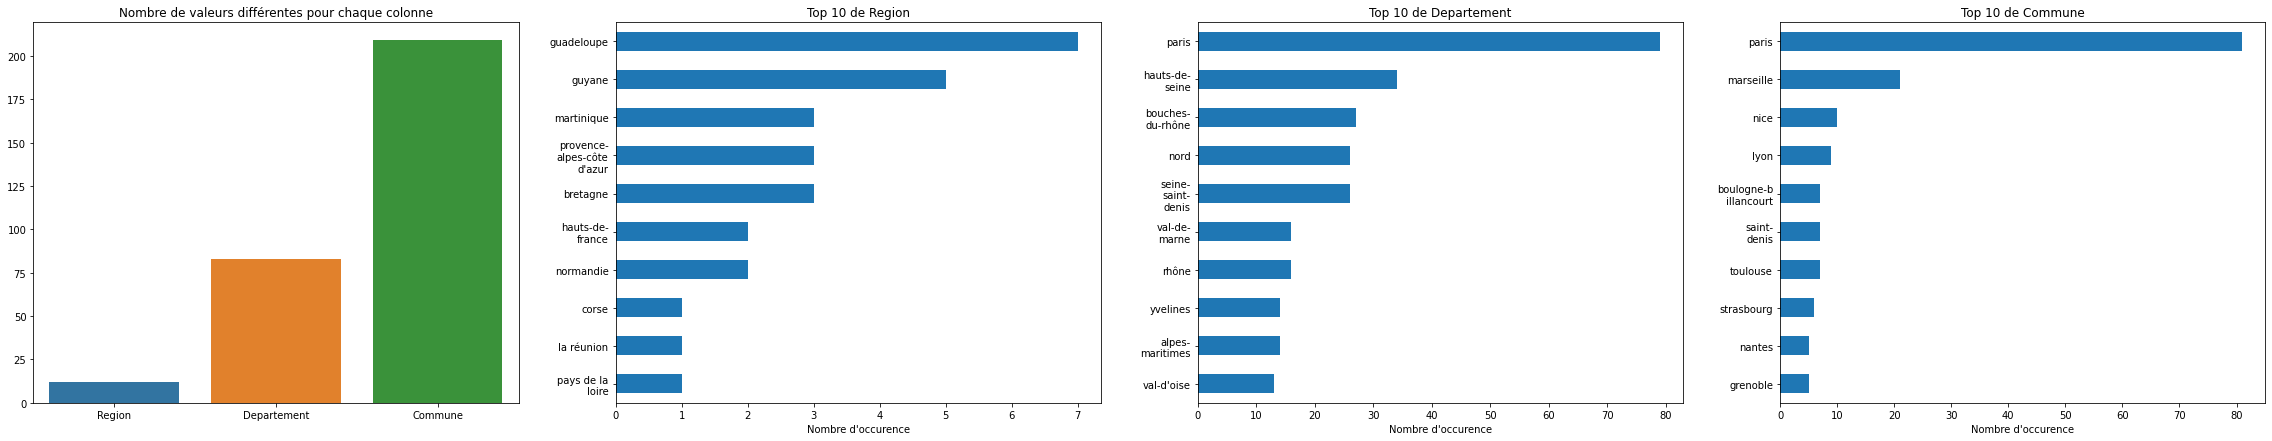

In [ ]:
category_count(["Region", "Departement", "Commune"], artist, top=10)

In [ ]:
#Permet de récupérer la région à partir du département
def departement_to_region(x : str):
    value = commune.loc[commune["nom_departement"] == x, "nom_region"].values
    if len(value) > 0:
        return value[0]
    else:
        return np.NaN

In [ ]:
#On ajoute les regions pour les departements
artist.loc[(~artist["Departement"].isna()) & (artist["Region"].isna()), "Region"] = artist.loc[(~artist["Departement"].isna()) & (artist["Region"].isna()), "Departement"].apply(departement_to_region)

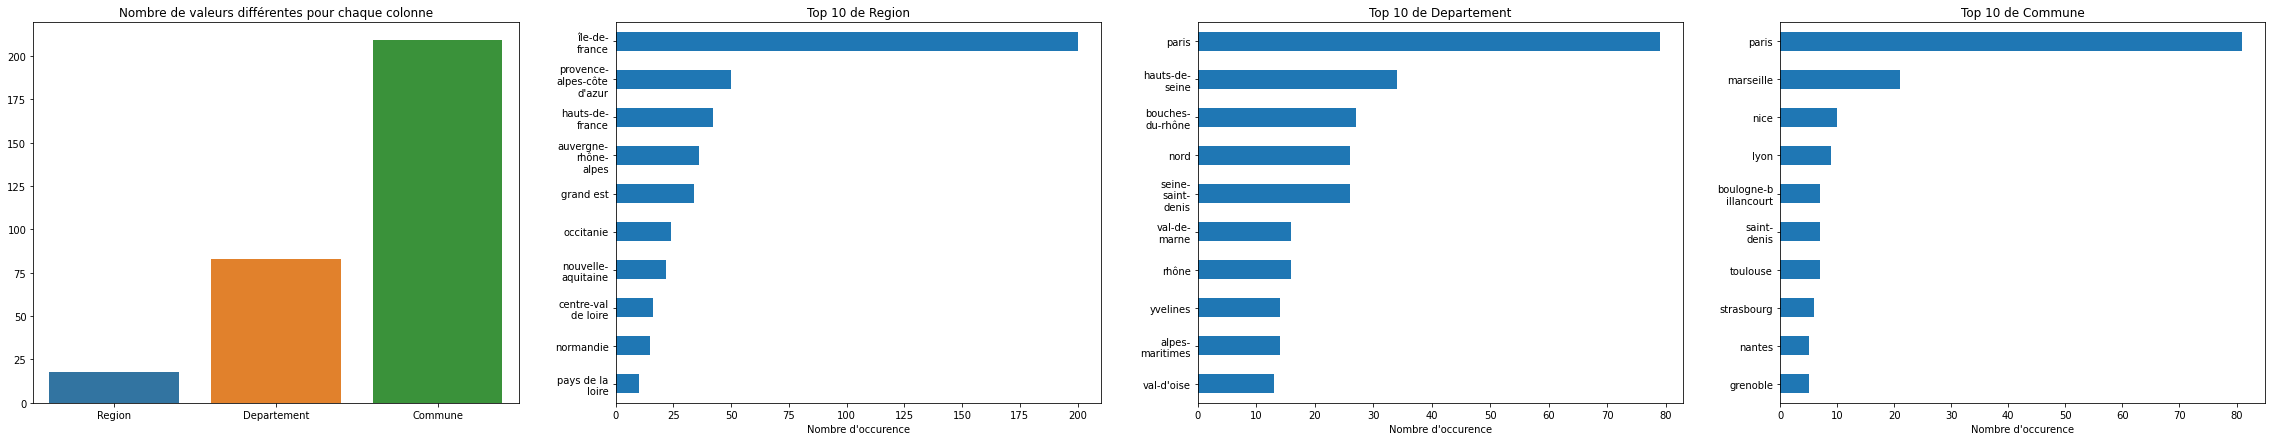

In [ ]:
category_count(["Region", "Departement", "Commune"], artist, top=10)

In [ ]:
charts_c = charts.copy().merge(artist, left_on="Artist", right_on="Artist", how="left").drop(columns=["Rank","Annee", "Mois"]).drop_duplicates()

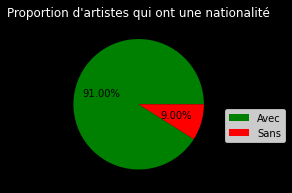

In [ ]:
pie_chart(artist, "Nationalité", "Proportion d'artistes qui ont une nationalité", True, ["Avec", "Sans"])

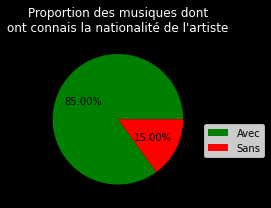

In [ ]:
pie_chart(charts_c, "Nationalité", "Proportion des musiques dont\nont connais la nationalité de l'artiste", True, ["Avec", "Sans"])

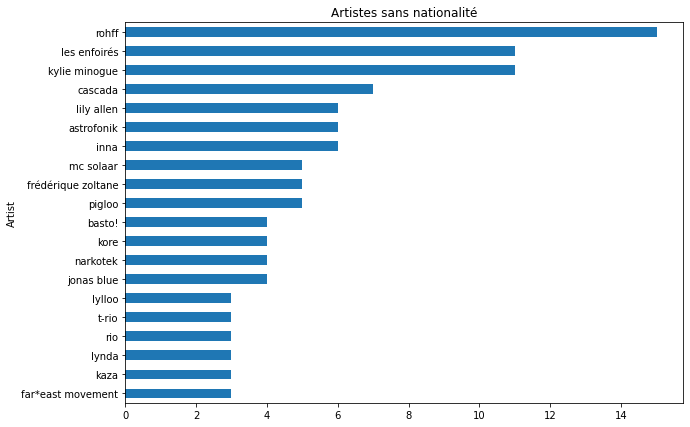

In [ ]:
charts_c[charts_c["Nationalité"].isna()].groupby("Artist")["Music"].count().sort_values()[-20:].plot.barh(figsize=(10,7))
plt.title("Artistes sans nationalité")
plt.show()

In [ ]:
artist.drop(columns=['No data', "No nationality", "No localisation"], inplace=True)

In [ ]:
artist = artist_org[["Artist"]].merge(artist, on="Artist", how="left")

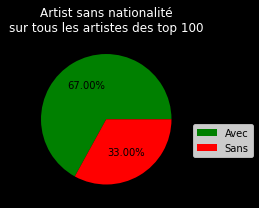

In [ ]:
pie_chart(artist, "Nationalité", "Artist sans nationalité\nsur tous les artistes des top 100", True, ["Avec", "Sans"])

In [ ]:
#Export
artist.to_csv("../etapes/4 - cleanning wikipedia results/departement_region/artist.csv", encoding="utf-8-sig", index=False)

## C - Ajout de l'id_artist

In [47]:
artist = pd.read_csv("../etapes/4 - cleanning wikipedia results/departement_region/artist.csv", encoding="utf-8-sig")
charts = pd.read_csv("../etapes/2 - cleanning chart/charts.csv", encoding="utf-8-sig")

In [48]:
# Ajout de l'id
artist = add_id(artist, ["Artist"], "id_artist")

In [49]:
# On remplace le nom des artistes par leur id dans le charts et on renome le nom de la colonne
charts["Artist"] = charts["Artist"].apply(lambda x : artist[artist["Artist"] == x]["id_artist"].values[0])
charts.rename(columns={"Artist" : "id_artist"}, inplace=True)

In [50]:
charts.to_csv("../etapes/4 - cleanning wikipedia results/add_id/charts.csv", encoding="utf-8-sig", index=False)
artist.to_csv("../etapes/4 - cleanning wikipedia results/add_id/artist.csv", encoding="utf-8-sig", index=False)

# Etape 5 : Scrapping parole

## A - Code

In [307]:
#Import
artist = pd.read_csv("../etapes/4 - cleanning wikipedia results/add_id/artist.csv", encoding="utf-8-sig")
charts = pd.read_csv("../etapes/4 - cleanning wikipedia results/add_id/charts.csv", encoding="utf-8-sig")

In [308]:
gentilles_francophones = [
    "africains",
    "sud-africains",
    "algériens",
    "belges",
    "beninois",
    "burkinabais",
    "burundais",
    "camerounais",
    "canadiens",
    "centrafricains",
    "congolais",
    "ivoiriens",
    "français",
    "gabonais",
    "guinéens",
    "haïtiens",
    "libanais",
    "maliens",
    "marocains",
    "mauriciens",
    "mauritaniens",
    "néo-zélandais",
    "québécois",
    "sénégalais",
    "tunisiens"
]

In [309]:
artist_francophone = artist[artist["Nationalité"].isin(gentilles_francophones)]

In [310]:
charts_francophone = charts.merge(artist_francophone, left_on="id_artist", right_on="id_artist", how="right")[["id_artist", "id_music", "Artist", "Music"]].drop_duplicates()

In [311]:
def find_lyrics(x):
    g = genius.Genius("19WnPxjd0b-zuJeynlxyOZ7UItqsAPQbVk3libvr4DsUGLgzyNjwp4jig6dMerlq")
    g.verbose = False
    try:
        song = g.search_song(title=x["Music"], artist=x["Artist"], get_full_info=False)
        return song.lyrics
    except:
        return np.NaN

In [64]:
charts_francophone["Lyrics"] = charts_francophone.apply(find_lyrics, axis=1)

In [319]:
musics = charts_francophone[["id_music", "id_artist", "Music", "Lyrics"]]

In [320]:
#export
musics.to_csv("../etapes/5 - scrapping lyrics/musics.csv", encoding="utf-8-sig", index=False)

## B - Analyse

In [321]:
#import
musics = pd.read_csv("../etapes/5 - scrapping lyrics/musics.csv", encoding="utf-8-sig")
artist = pd.read_csv("../etapes/4 - cleanning wikipedia results/add_id/artist.csv", encoding="utf-8-sig")

In [322]:
data = musics.merge(artist, on="id_artist", how="left")

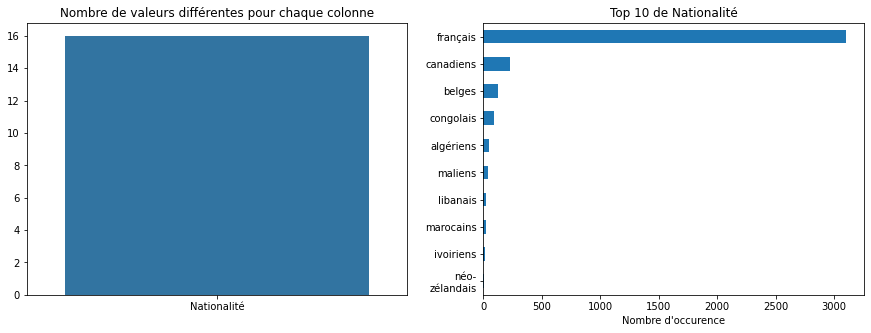

In [323]:
category_count(["Nationalité"], data, (15,5))

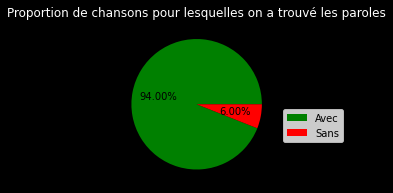

In [324]:
pie_chart(charts_francophone, "Lyrics", "Proportion de chansons pour lesquelles on a trouvé les paroles", True, ["Avec", "Sans"])

# Etape 6 : Cleaning des paroles

## A - Cleaning

In [325]:
#import
musics = pd.read_csv("../etapes/5 - scrapping lyrics/musics.csv", encoding="utf-8-sig")

In [326]:
def remove_translation(lyrics:str):
    start = lyrics.split(" Lyrics")[0]
    isUpperNum = [k for k, l in enumerate(start) if l.isupper() or l.isnumeric()]
    idx = isUpperNum[-1]

    k = 2
    while lyrics[idx-1] in ["-", " ", ".", "(", "&", "/"] or lyrics[idx-1].isupper() or lyrics[idx-1].isnumeric():
        idx = isUpperNum[-k]
        k += 1
        
    return lyrics[idx:]

In [327]:
def check_good_lyrics_without_translation(lyrics, title, p=0.3):
    if lyrics is np.NaN:
        return False
    
    song_title_lyrics = lyrics.lower().split(" lyrics")[0]
    song_title_lyrics_without_parent = re.sub(r" [\(\[].*?[\)\]]", "", song_title_lyrics)
    distance_without = edit_distance(song_title_lyrics_without_parent, title.lower())
    distance = edit_distance(song_title_lyrics, title.lower())

    return distance/len(title) <= p or distance_without/len(title) <= p

In [328]:
def check_good_lyrics_with_translation(lyrics, title, p=0.3):
    if lyrics is np.NaN:
        return False

    song_title_lyrics = lyrics.lower().split(" lyrics")[0]
    song_title_lyrics = song_title_lyrics[-len(title):]
    distance = edit_distance(song_title_lyrics, title.lower())
    return distance/len(title) <= p

In [329]:
def remove_title_lyrics(lyrics:str):
    idx = re.search(" lyrics", lyrics.lower()).span()[1]
    return lyrics[idx:]

In [330]:
def remove_crochet(lyrics:str):
    lyrics = re.sub(r"[\(\[].*?[\)\]]", "", lyrics)
    lyrics = re.sub(r"\n", " ", lyrics)
    lyrics = re.sub(" +", " ", lyrics)
    return lyrics

In [331]:
def cleanning_lyrics(row):
    lyrics = row["Lyrics"]
    title = row["Music"]

    if lyrics is np.NaN:
        return np.NaN

    if "lyrics" in title:
        raise ValueError("Y'a le mot lyrics dans le titre")
        
    # On s'occupe des paroles qui ont des traductions
    if lyrics.lower().startswith("translation"):
        if not check_good_lyrics_with_translation(lyrics, title) and not check_good_lyrics_without_translation(remove_translation(lyrics), title):
            return np.NaN
        else:
            lyrics = remove_translation(lyrics)
    else:
        if not check_good_lyrics_without_translation(lyrics, title):
            return np.NaN

    # On met tous en minuscule
    lyrics = lyrics.lower()

    # On enleve le titre du debut
    lyrics = remove_title_lyrics(lyrics)
        
    # On enleve les crochets
    lyrics = remove_crochet(lyrics)

    # On enleve le 'embed' a la fin
    if lyrics.endswith("embed"):
        lyrics = lyrics[:-5]

    lyrics = lyrics.strip()

    return lyrics

In [332]:
musics["Lyrics"] = musics.apply(cleanning_lyrics, axis=1)

<strong> J'ai des musiques qui ne sont pas en VO </strong>

In [333]:
#export
musics.to_csv("../etapes/6 - cleaning lyrics/musics.csv", encoding="utf-8-sig", index=False)

## B - Analyse

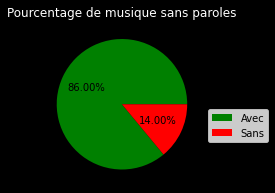

In [334]:
pie_chart(musics, "Lyrics", "Pourcentage de musique sans paroles", True, ["Avec", "Sans"])

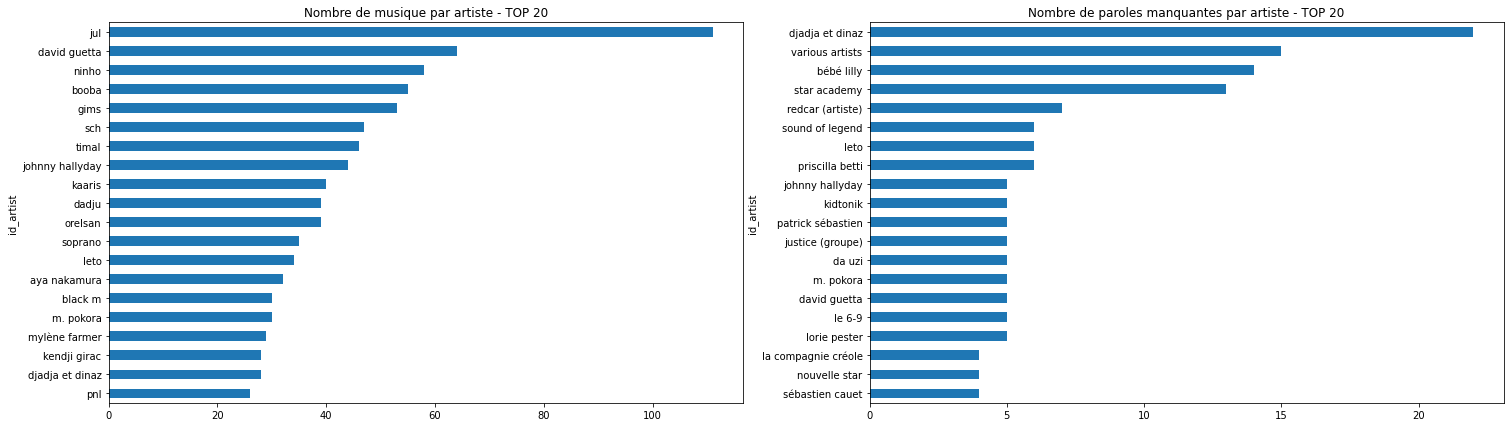

In [335]:
top = 20

fig, ax = plt.subplots(1, 2, figsize=(25, 7))

musics.groupby("id_artist")["Music"].count().sort_values(ascending=True).iloc[-top:].plot.barh(ax=ax[0])
ax[0].set_yticklabels([artist[artist["id_artist"] == int(label.get_text())]["Artist"].values[0] for label in ax[0].get_yticklabels()])
ax[0].set_title(f"Nombre de musique par artiste - TOP {top}")

musics[musics["Lyrics"].isna()].groupby("id_artist")["Music"].count().sort_values(ascending=True).iloc[-top:].plot.barh(ax=ax[1])
ax[1].set_yticklabels([artist[artist["id_artist"] == int(label.get_text())]["Artist"].values[0] for label in ax[1].get_yticklabels()])
ax[1].set_title(f"Nombre de paroles manquantes par artiste - TOP {top}")

plt.show()

# Etape 7 - Lematization/Tokenization

## A - Spacy FR

In [336]:
#import
musics = pd.read_csv("../etapes/6 - cleaning lyrics/musics.csv", encoding="utf-8-sig")

In [337]:
# Charge le modèle de langue française
nlp = spacy.load("fr_core_news_sm")

In [338]:
def is_french(string):
    if string is np.NaN:
        return False

    doc = nlp(string)
    return doc.lang_ == "fr"

In [339]:
musics["is french"] = musics["Lyrics"].apply(is_french)

In [340]:
#export
musics.to_csv("../etapes/7 - lematization/isFrench/musics.csv", encoding="utf-8-sig", index=False)

## B - TF-IDF

In [8]:
musics = pd.read_csv("../etapes/7 - lematization/isFrench/musics.csv", encoding="utf-8-sig")

In [15]:
nlp = spacy.load("fr_core_news_sm")

In [18]:
def lematization(lyrics : str, nlp : spacy.lang):
    lyrics_lemma = [token.lemma_ for token in nlp(lyrics) if not token.is_stop]
    return " ".join(lyrics_lemma)

In [19]:
def tfidf_mat(corpus : list):
    tfidf = TfidfVectorizer()
    mat = tfidf.fit_transform(corpus)
    return pd.DataFrame(mat.toarray(), columns=tfidf.get_feature_names_out())

In [22]:
musics = musics[musics["is french"]]
lyrics_lematization = musics["Lyrics"].apply(lambda x : lematization(x, nlp))

In [25]:
tfidf = tfidf_mat(lyrics_lematization)

In [34]:
tfidf.index = musics["id_music"].to_list()

In [35]:
tfidf

,000,06,09,10,100,1000,1000x80x73,100k,101,103,...,زيد,شطح,عليك,عود,واحد,وحدة,يا,在中間,在中間you,站在中間
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
363,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5720,0.0,0.0,0.0,0.045777,0.050339,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6100,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6100,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5101,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
tfidf.to_csv("../etapes/7 - lematization/tfidf/tfidf.csv", encoding="utf-8-sig")

KeyboardInterrupt: 

## B - Analyse

In [343]:
#import
musics = pd.read_csv("../etapes/7 - lematization/isFrench/musics.csv", encoding="utf-8-sig")

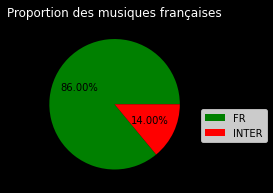

In [341]:
pie_chart(musics, "is french", "Proportion des musiques françaises", False, ["FR", "INTER"])

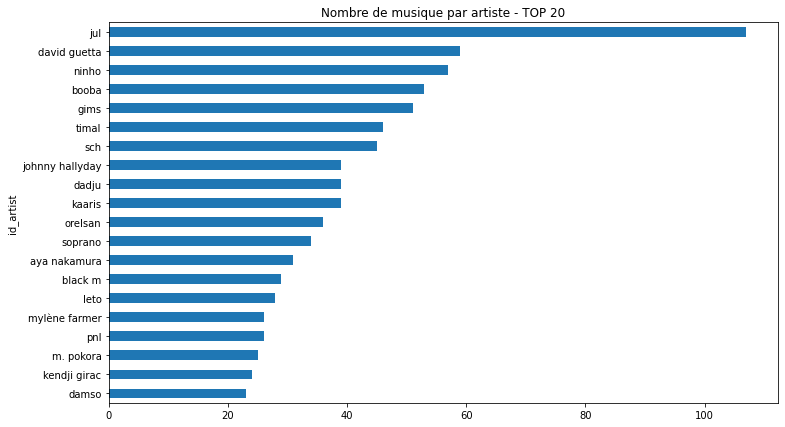

In [342]:
top = 20

musics = musics[musics["is french"]]

fig, ax = plt.subplots(figsize=(12, 7))

musics.groupby("id_artist")["Music"].count().sort_values(ascending=True).iloc[-top:].plot.barh(ax=ax)
ax.set_yticklabels([artist[artist["id_artist"] == int(label.get_text())]["Artist"].values[0] for label in ax.get_yticklabels()])
ax.set_title(f"Nombre de musique par artiste - TOP {top}")

plt.show()

# Maps

In [ ]:
#Import
artist = pd.read_csv("../etapes/4 - cleanning wikipedia results/departement_region/artist.csv", encoding="utf-8-sig", index_col=0)

In [ ]:
departement_df = gpd.read_file("../departements-et-collectivites-doutre-mer-france/georef-france-departement-millesime.shp", encoding="utf-8")

In [ ]:
region_df = gpd.read_file("../departements-et-collectivites-doutre-mer-france/regions-20180101.shp")

In [ ]:
nom_to_suppr = ["Guyane", "La Réunion", "Corse", "Martinique", "Guadeloupe", "Mayote"]
region_df = region_df[~region_df["nom"].isin(nom_to_suppr)]

In [ ]:
#Remove overseas departments
idx = []
for dp in ["971", "972", "973", "974", "976"]:
    idx += departement_df[departement_df["dep_code"] == dp].index.tolist()
departement_df.drop(index=idx, inplace=True)

In [ ]:
departement_map = departement_df[["dep_name_lo", "geometry"]].copy()
region_map = region_df[["nom", "geometry"]].copy()

In [ ]:
region_map["nom"] = region_map["nom"].str.lower()

In [ ]:
departement_count = artist.copy().groupby("Departement")["Artist_wiki"].count()
region_count = artist.copy().groupby("Region")["Artist_wiki"].count()

In [ ]:
departement_count = pd.DataFrame(departement_count).merge(departement_map, left_on="Departement", right_on="dep_name_lo", how="left")
region_count = pd.DataFrame(region_count).merge(region_map, left_on="Region", right_on="nom", how="left")

In [ ]:
departement_count = gpd.GeoDataFrame(departement_count, geometry="geometry")
region_count = gpd.GeoDataFrame(region_count, geometry="geometry")

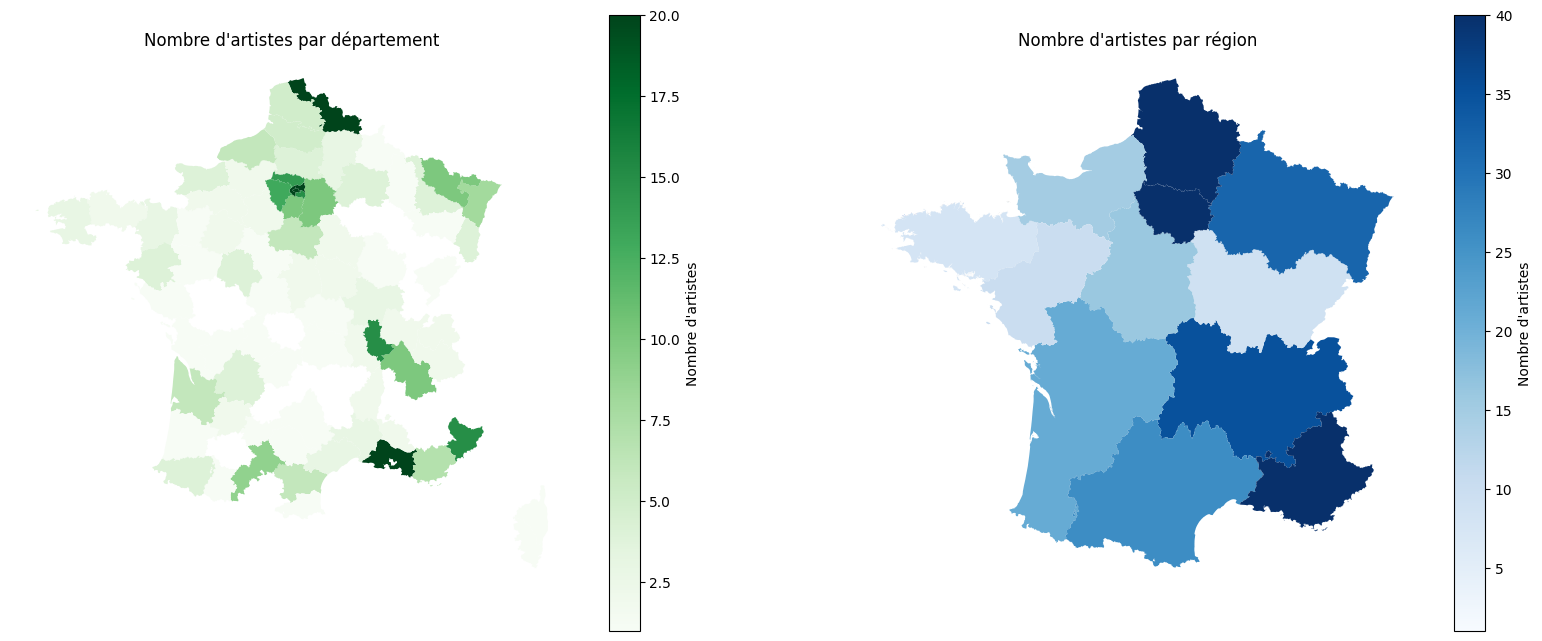

In [ ]:
#Plot departement and region on map
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
departement_count.plot(column="Artist_wiki", ax=ax[0], legend=True, legend_kwds={'label': "Nombre d'artistes"}, vmax=20, cmap="Greens")
region_count.plot(column="Artist_wiki", ax=ax[1], legend=True, legend_kwds={'label': "Nombre d'artistes"}, vmax=40, cmap="Blues")
ax[0].set_title("Nombre d'artistes par département")
ax[0].axis("off")
ax[1].set_title("Nombre d'artistes par région")
ax[1].axis("off")
plt.show()